# KE5105 - Building Electrical Consumption Forecasting

# Modelling 11 - Fine-tune model

## Summary of Findings
* **MRB building data**
* Stateful 4x128 GRU, 2x32 Dense
	* Min Validation MAE (normalised) = 2.447 (0.0180) @ epoch 223

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline

from keras import layers
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.regularizers import l1,l2, l1_l2
from keras.callbacks import ModelCheckpoint, TensorBoard

## Load data for building MRB

In [5]:
mrb_train = mu.load_data_by_bldg(['MRB'], 'imputed_train')

In [6]:
mrb_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31617 entries, 2015-06-12 07:30:00 to 2017-03-31 23:30:00
Data columns (total 10 columns):
PWMMRIC1                     29851 non-null float64
PWMMRIC2                     29851 non-null float64
BTUMochtarRiady              29448 non-null float64
PWMMRIC1_30min_avg           29818 non-null float64
PWMMRIC2_30min_avg           29818 non-null float64
BTUMochtarRiady_30min_avg    29416 non-null float64
PWM_sumadd                   29818 non-null float64
PWM_30min_avg                29861 non-null float64
BTU_sumadd                   29416 non-null float64
BTU_30min_avg                29469 non-null float64
dtypes: float64(10)
memory usage: 2.7 MB


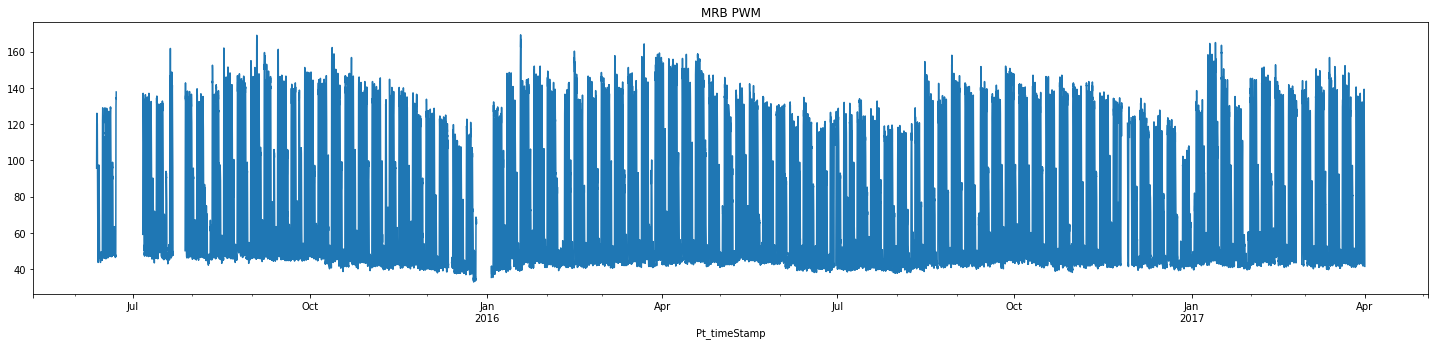

In [7]:
mrb_train_df = mrb_train[0][1]
mrb_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='MRB PWM')

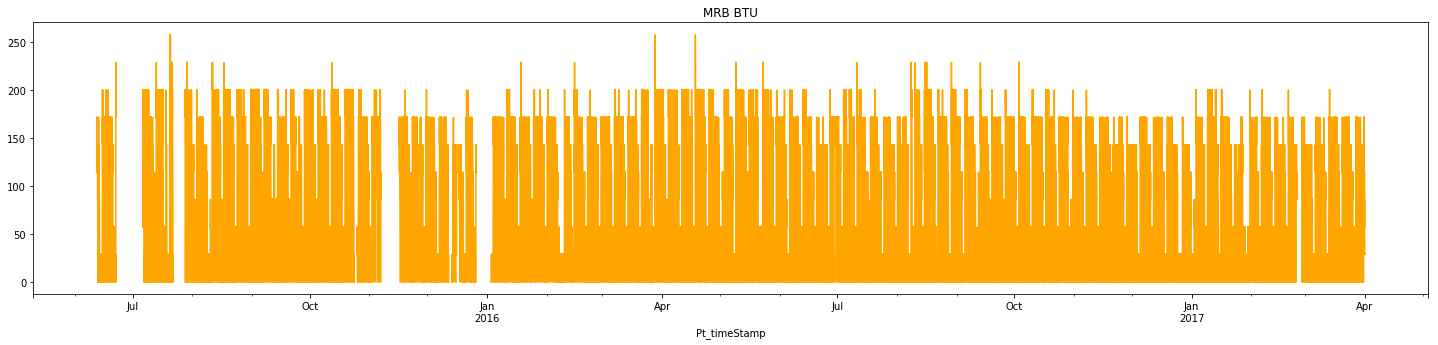

In [8]:
mrb_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='MRB BTU', color='orange')

## Split a validation set out from the train set

In [9]:
mrb_train_split_df = mrb_train_df[:20000]
mrb_val_split_df = mrb_train_df[20000:]

In [10]:
print('train split = %s\nvalidation split = %s' % (mrb_train_split_df.shape, mrb_val_split_df.shape))

train split = (20000, 10)
validation split = (11617, 10)


## Transform the training data
* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [11]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    # ('yeo-johnson_transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [12]:
mrb_train_data = my_pipeline.fit_transform(mrb_train_split_df)
mrb_train_data

array([[0.46055046, 0.66601942],
       [0.55412844, 0.66699029],
       [0.60366972, 0.66601942],
       ...,
       [0.16880734, 0.11067961],
       [0.07889908, 0.11067961],
       [0.07155963, 0.        ]])

In [13]:
mrb_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

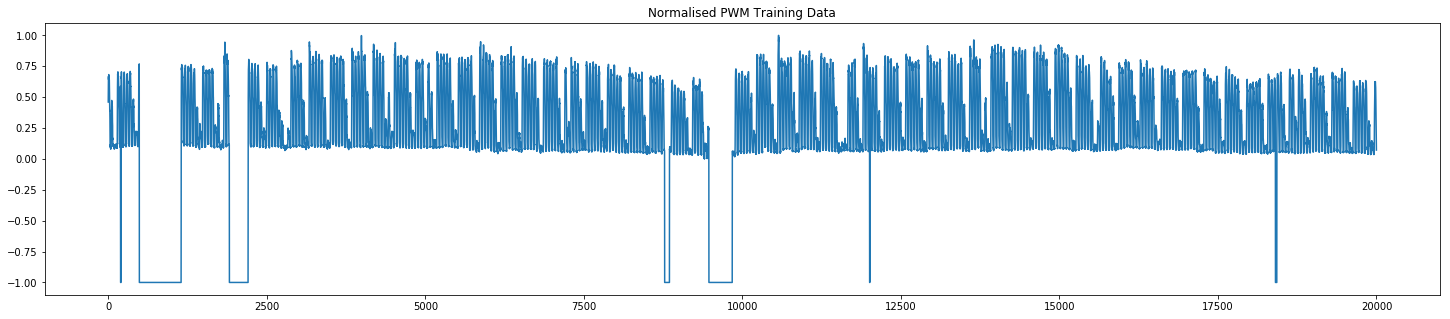

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 0])
plt.title('Normalised PWM Training Data')

In [24]:
# There are no zero PWM values in the traing mini-batches.
batch_list, rows_list = mu.get_contiguous_batches(mrb_train_data, lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1, batch_size=lookback, step=step)
np.any(mrb_train_data[[ j for i in rows_list for j in i ], 0] == 0)

False

Text(0.5, 1.0, 'Normalised BTU Training Data')

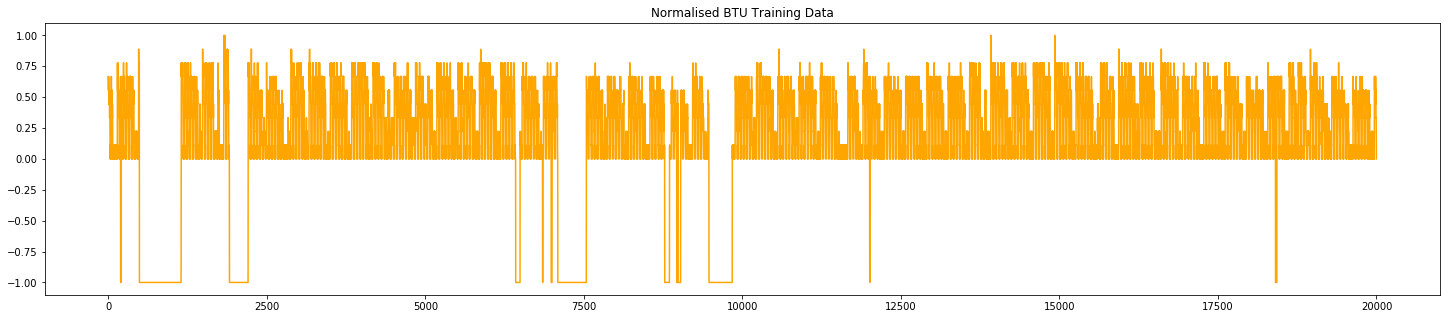

In [15]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_train_data.shape[0]), mrb_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [16]:
mrb_val_data = my_pipeline.transform(mrb_val_split_df)
mrb_val_data

array([[0.05321101, 0.        ],
       [0.07155963, 0.11067961],
       [0.05688073, 0.        ],
       ...,
       [0.13211009, 0.11067961],
       [0.10825688, 0.11426533],
       [0.06314127, 0.11424788]])

In [17]:
mrb_val_data.shape

(11617, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

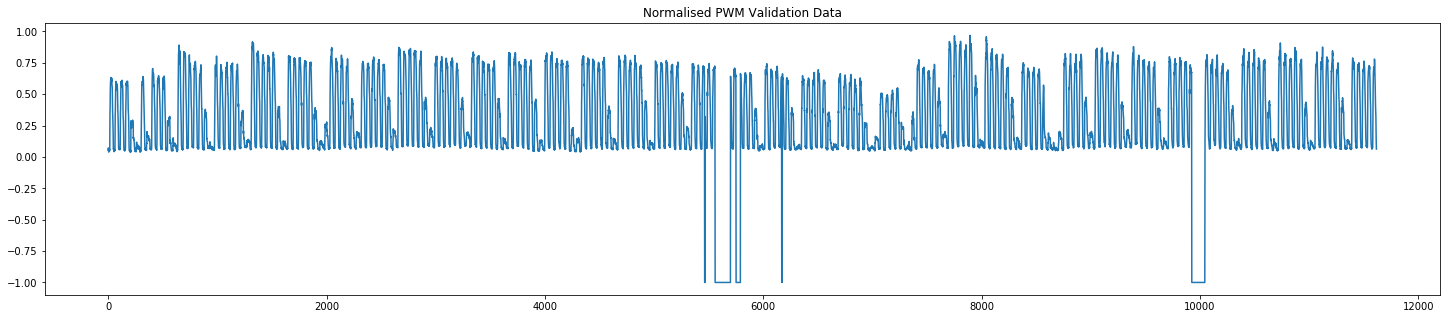

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

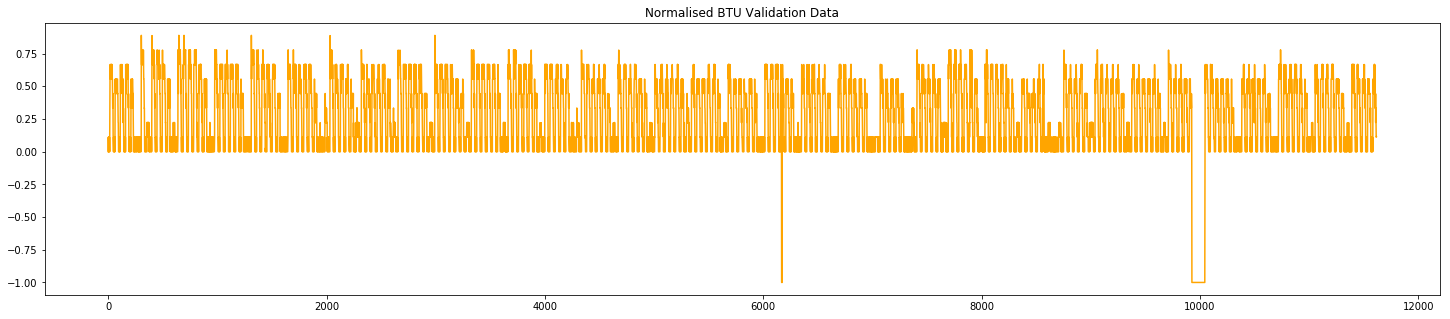

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(range(mrb_val_data.shape[0]), mrb_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [20]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## 4x128 GRU, 2x32 Dense Layer Stateful Model

In [21]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [22]:
model = Sequential()
# model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(batch_size, lookback, mrb_train_data.shape[-1]), stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(lookback, lookback, mrb_train_data.shape[-1]), stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
model.add(layers.CuDNNGRU(128, stateful=True))
model.add(layers.Dense(32, activation='relu'))  # use relu to avoid vanishing gradients
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))  # cannot use sigmoid to get an easy to compute loss gradient (cross-entropy with sigmoid has easy derivative) because output can be > 1
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (240, 128)                99072     
_________________________________________________________________
dense_1 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_2 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_3 (Dense)              (240, 1)                  33        
Total para

In [23]:
# Using lookback as the batch size.
gen_train = mu.DataGeneratorForStateFulRNN(mrb_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
                             batch_size=lookback, step=step)
print('train batches = %d' % gen_train.__len__())

train batches = 74


In [24]:
histories = []

In [23]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base1mrb-stateful-4x128gru-2x32dense-histories-epch300.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base1mrb-stateful-4x128gru-2x32dense-epch300.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (240, 128)                99072     
_________________________________________________________________
dense_1 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_2 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_3 (Dense)              (240, 1)                  33        
Total para

#### Custom validation score callback

In [27]:
val_cb = mu.ValidationScoreCb(mrb_val_data, lookback, delay, min_index=0, max_index=len(mrb_val_data) - 1, batch_size=lookback, step=step, verbose=0, save_model = True)

In [29]:
# sanity check for validation set
batch_list, rows_list = mu.get_contiguous_batches(mrb_val_data, lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1, batch_size=lookback, step=step)
n_samples = [ sample for batch in rows_list for sample in batch ]
print(len(n_samples), mrb_val_data.shape)

10320 (11617, 2)


#### Train the model

In [30]:
callbacks_list = [
    TensorBoard(
        log_dir='tsb_log'
    ),
    mu.ResetStateCb(gen_train),
    val_cb
]

In [47]:
train_to_epoch = 400
start_epoch = 300

t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=train_to_epoch,
                              callbacks=callbacks_list, initial_epoch=start_epoch,
                              workers=2, use_multiprocessing=False, shuffle=False, verbose=0)  # shuffle = False!!
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

histories.append({**history.history, **val_cb.history})

Training start time = 2019-03-05 15:15:22.904042

Training Duration = 0:17:20.125816


In [48]:
model.save('base1mrb-stateful-4x128gru-2x32dense-epch' + str(train_to_epoch) + '.h5')

In [49]:
with open('base1mrb-stateful-4x128gru-2x32dense-histories-epch' + str(train_to_epoch) + '.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

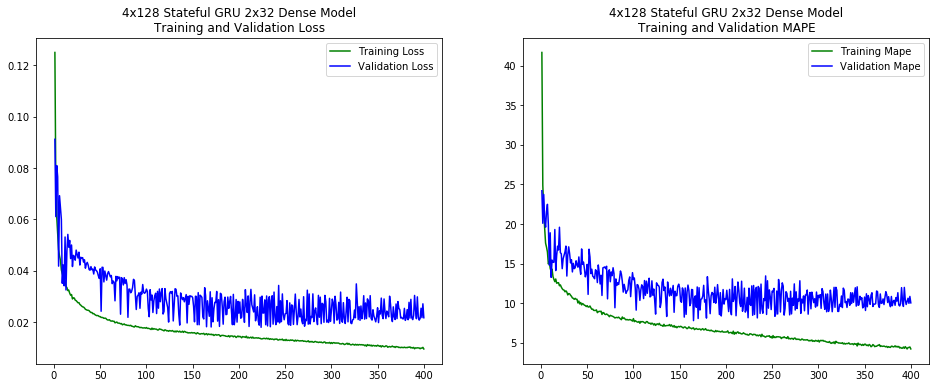

In [50]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 Stateful GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 Stateful GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [51]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.009525
Validation min loss = 0.017962
Validation min epoch = 223


In [52]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (mrb_train_split_df['PWM_30min_avg'].max() - mrb_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 1.297756
Validation MAE = 2.447364


In [53]:
# Load best model
best_model = Sequential()
# model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(batch_size, lookback, mrb_train_data.shape[-1]), stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(lookback, lookback, mrb_train_data.shape[-1]), stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
best_model.add(layers.CuDNNGRU(128, stateful=True))
best_model.add(layers.Dense(32, activation='relu'))  # use relu to avoid vanishing gradients
best_model.add(layers.Dense(32, activation='relu'))
best_model.add(layers.Dense(1))  # cannot use sigmoid to get an easy to compute loss gradient (cross-entropy with sigmoid has easy derivative) because output can be > 1


best_model.load_weights(os.path.join('models', 'base1mrb-stateful-4x128gru-2x32dense-weights-best-epch223.h5'))

best_model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_9 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_10 (CuDNNGRU)      (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_12 (CuDNNGRU)      (240, 128)                99072     
_________________________________________________________________
dense_7 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_8 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_9 (Dense)              (240, 1)                  33        
Total para

In [54]:
# gen_pred = mu.DataGenerator(
#     mrb_train_data,
#     lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1,
#     batch_size=lookback, step=step)
# mrb_train_preds = best_model.predict_generator(gen_train_pred, workers=3, use_multiprocessing=False)

batch_list, rows_list = mu.get_contiguous_batches(mrb_train_data, lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_train_data) - 1, batch_size=lookback, step=step)
mrb_train_preds_list = []
for a_batch in batch_list:
    mrb_train_preds_list.append(best_model.predict(a_batch[0], batch_size=lookback))
mrb_train_preds = np.concatenate(mrb_train_preds_list)
mrb_train_preds.shape
# There are 74 training mini-batches which is 17760 samples

(17760, 1)

In [55]:
mrb_train_preds1 = np.concatenate([mrb_train_preds, np.zeros((mrb_train_preds.shape[0], 1))], axis=1)
mrb_train_preds1.shape

(17760, 2)

In [56]:
mrb_train_preds1 = my_pipeline.inverse_transform(mrb_train_preds1)
mrb_train_preds1

array([[ 92.78397936,   0.        ],
       [109.47323221,   0.        ],
       [117.77155194,   0.        ],
       ...,
       [ 40.18504844,   0.        ],
       [ 40.38117735,   0.        ],
       [ 40.18553571,   0.        ]])

In [57]:
mrb_train_preds_withnan = np.full((mrb_train_data.shape[0] - delay, 1), np.NaN)
j = 0
all_rows = np.concatenate(rows_list)
for i in range(lookback, len(mrb_train_data)):
    # if mrb_train_data[i, 0] > -1:
    if i in all_rows:
        mrb_train_preds_withnan[i] = mrb_train_preds1[j, 0]
        j += 1
mrb_train_preds_withnan.shape

(20000, 1)

In [58]:
# gen_val_pred = mu.DataGenerator(mrb_val_data,
#                                 lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1,
#                                 batch_size=batch_size, step=step)
# mrb_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)

batch_list, rows_list = mu.get_contiguous_batches(mrb_val_data, lookback=lookback, delay=delay, min_index=0, max_index=len(mrb_val_data) - 1, batch_size=lookback, step=step)
mrb_val_preds_list = []
for a_batch in batch_list:
    mrb_val_preds_list.append(best_model.predict(a_batch[0], batch_size=lookback))
mrb_val_preds = np.concatenate(mrb_val_preds_list)
mrb_val_preds.shape

(10320, 1)

In [59]:
mrb_val_preds1 = np.concatenate([mrb_val_preds, np.zeros((mrb_val_preds.shape[0], 1))], axis=1)
mrb_val_preds1 = my_pipeline.inverse_transform(mrb_val_preds1)
mrb_val_preds_withnan = np.full((mrb_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(mrb_val_data)):
    # if mrb_val_data[i, 0] > -1:
    if i in all_rows:
        mrb_val_preds_withnan[i] = mrb_val_preds1[j, 0]
        j += 1
mrb_val_preds_withnan.shape

(11617, 1)

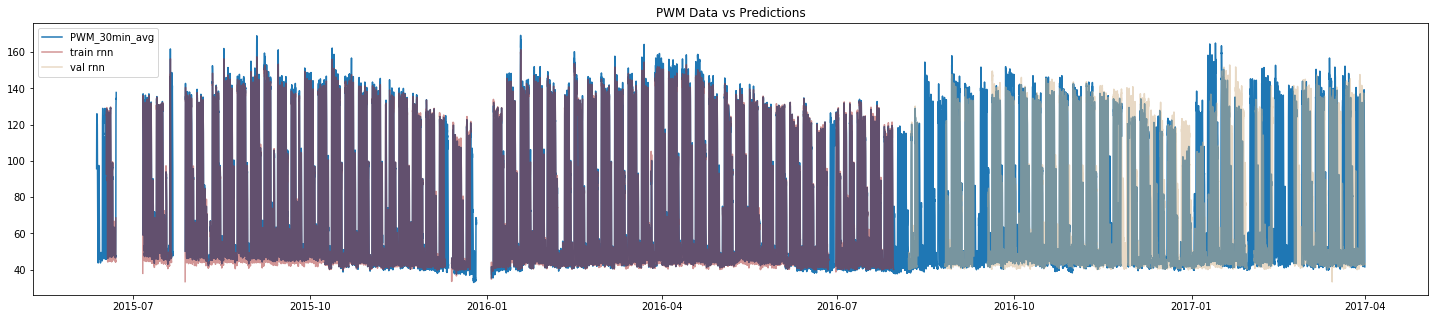

In [60]:
plt.figure(figsize=(25, 5))
plt.plot(mrb_train_df['PWM_30min_avg'])
plt.plot(mrb_train_df.index[:20000], mrb_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(mrb_train_df.index[20000:], mrb_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

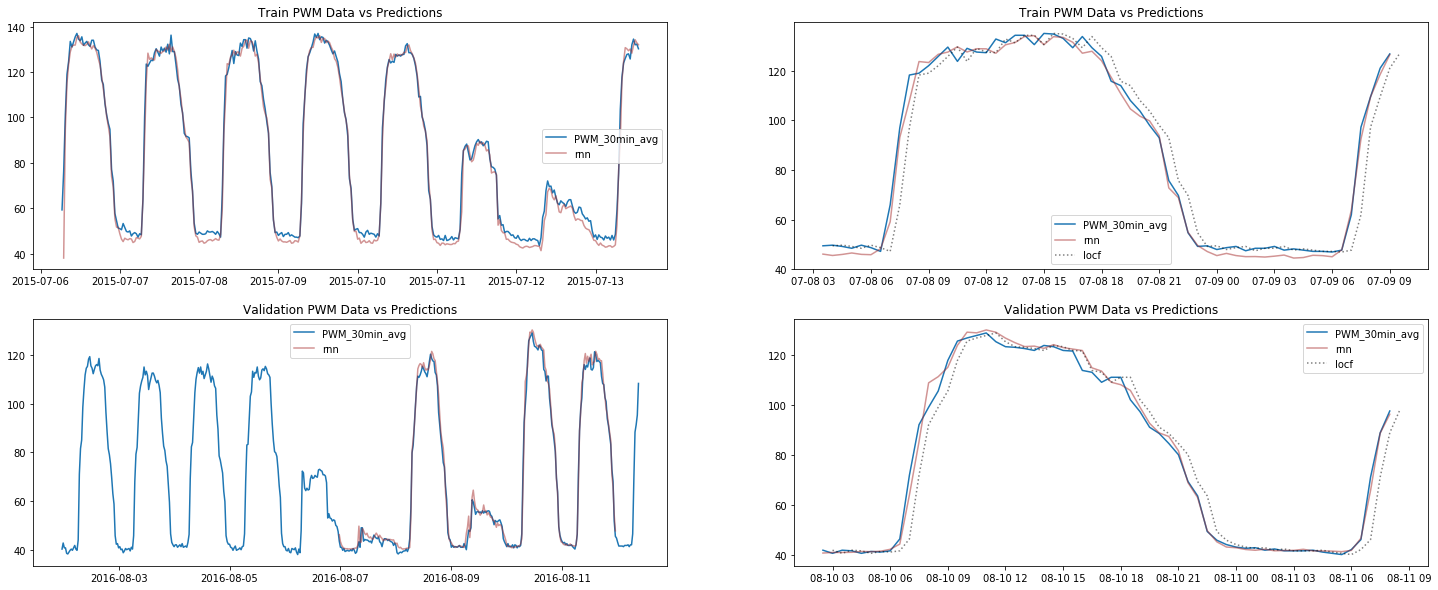

In [61]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(mrb_train_df.iloc[1000:1500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1000:1500], mrb_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[1240:1300], mrb_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[1241:1301], mrb_train_df.iloc[1240:1300, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(mrb_train_df.iloc[20000:20500, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20000:20500], mrb_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(mrb_train_df.index[20390:20450], mrb_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(mrb_train_df.index[20391:20451], mrb_train_df.iloc[20390:20450, mrb_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()